# AIAIART #2 - Learning Representations

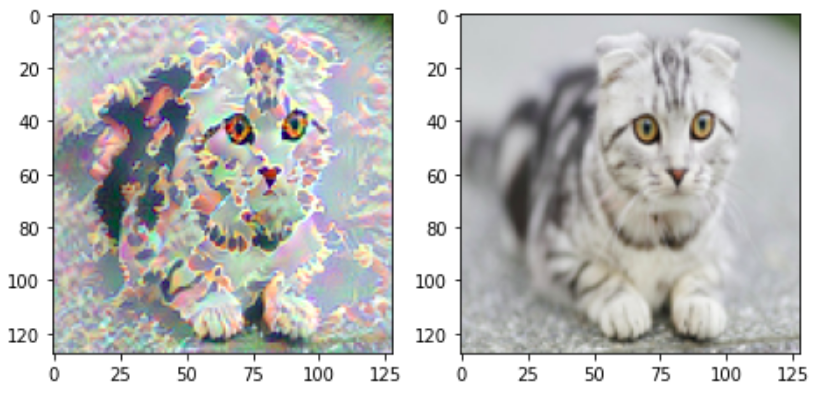

Last week we saw how we can optimise a set of parameters of some arbitrary function to (hopefully) reduce some loss. In the process we got familiar with some PyTorch building blocks, and by the end we'd even made some pretty pictures by treating CLIP as a magical balck box. One thing we didn't speak about at all is neural networks. Today we fix that :)

We'll look at how to create simple NNs in PyTorch, and then take a quick look at some of the improvements that have made deep learning models so good in recent years. We'll see that a key feature that makes deep learning models so useful is that they are able to learn good representations. 

By taking advantage of some of the inner representations learnt by a pre-trained convolutional neural network, we'll optimize an image to have the 'style' of one picture and the 'content' of another (style transfer). These sorts of network-based loss functions can be useful in all sorts of contexts.

Moving on from there, we'll shift gear and ask a new question: how can we learn a representation that is useful for generating images (rather than simply classifying them)? And how do we extend this into a model that can generate novel yet plausible new images based on a training set? This will lay the groundwork for GANs which we'll meet in lesson 3.

Finally, as a bonus at the end we'll take one of our toy generative models and mash it together with CLIP to make some weird pictures :)

Last week's lesson: https://colab.research.google.com/drive/1pp8hS5C6RTMpOLBJMwnx3d7JjicqgJKx?usp=sharing

In [1]:
os.environ["CUDA_VISIBLE_DEVICES"] = '6,7'
#@title Setup and Imports (run this first)
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

# Adding on from last lesson:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm


# Downloading the MNIST dataset we'll use in examples
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been dowloaded.\n')

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Section 1: PyTorch for ANNs

PyTorch is designed to make building and training neural networks as easy as possible. This means there are lots of built-in classes and methods that will make our lives easier :) 

Here's a video that gives a good overview of some of these classes which we'll going to use:



In [2]:
#@title PyTorch nn module (NMA video)
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/jzTbQACq7KE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

/home/chenweifeng/anaconda3/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### 1.1 A Simple Neural Network

Let's start by making a smallish network to solve a small (contrived) problem. We'll generate some data, and as in the first lesson we'd like our network to learn the relationship between our input data (x) and output data (y).

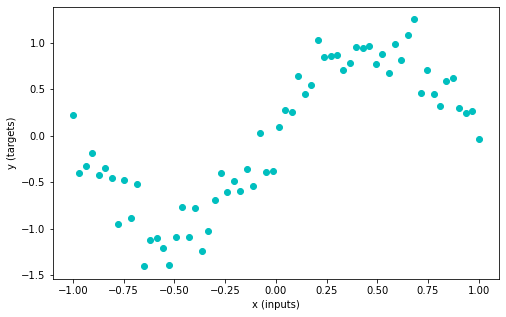

In [3]:
#@title Generating some data (inputs and targets)
n_samples = 64
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 5
targets = torch.sin(3.14 * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Here's how we can make a neural network, leaning on PyTorch's handy functions:

In [4]:
## A Wide neural network with a single hidden layer
class WideNet(nn.Module):

  def __init__(self, n_cells=512): # Initialize our network
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells), # One input, n_cells outputs
        nn.Tanh(), # Our non-linearity - there are many on offer!
        nn.Linear(n_cells, 1), # n_cells inputs, one output
    )

  def forward(self, x):
    return self.layers(x)

We're inheriting from the nn.Module class, which gives us some bonus features. For example, instead of directly calling the `forward` method (which passes the data through the different layers) we can just create our network and call it like a function:

In [5]:
wn = WideNet()
print('Input shape:', inputs.shape)
out = wn(inputs) # This passes our data in as the input to the forward method defined above
print('Output shape:', out.shape)
print('PyTorch sumary of wn:')
wn

Input shape: torch.Size([64, 1])
Output shape: torch.Size([64, 1])
PyTorch sumary of wn:


WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

Time for our training loop - compare this with the optimization loop we saw last week (spoiler: they're the same!). We're optimizing the parameters of our neural network - all the weights and biases in the different layers.

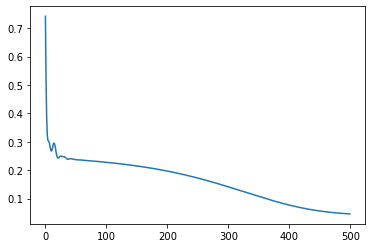

In [6]:
# Create our network
wide_net = WideNet()

# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer
optimizer = torch.optim.Adam(wide_net.parameters(), lr=1e-3)

# The training loop
losses = []  # keeping recods of loss
for i in range(500): # 500 'epochs' of training
  optimizer.zero_grad()  # set gradients to 0
  predictions = wide_net(inputs)  # Compute model prediction (output)
  loss = loss_function(predictions, targets)  # Compute the loss
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step)

  # Storing our loss for later viewing
  losses.append(loss.item())

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

**THINK/DISCUSS**: Go line-by-line through the code above - does it make sense?

Notice we don't have to set requires_grad manually on any of the parameters, since the learnable parameters in each layer are grouped automatically by `wide_net.parameters()` (inspect that and see what it contains). 

We can see if our network as indeed learnt the relationship that we wanted it to learn:

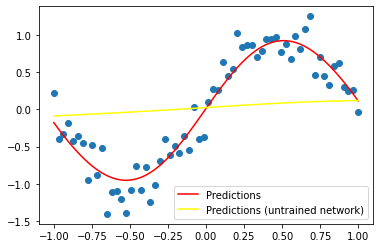

In [7]:
#@title Plot the predictions vs the actual data
plt.scatter(inputs, targets)
plt.plot(inputs, wide_net(inputs).detach(), c='red', label='Predictions')
# Create a new, untrained widenet and plot those predictions for comparison
new_wn = WideNet()
plt.plot(inputs, new_wn(inputs).detach(), c='yellow', label='Predictions (untrained network)')
plt.legend()
plt.show()

In [8]:
# Exercise: Create a neural network with two hidden layers and train it on this same task...

# Section 2: A Lightning Overview of ConvNets

So-called 'dense' networks are useful in some cases, but we need to be mindful of the number of parameters required to solve certain types of problems. For example, consider the case of image recognition - our inputs consist of thousands of individual pixel values. A dense network that could take in 500px images and then run them through many hidden layers ends up with millions or billions of parameters, which can make training tricky. 

In addition, each pixel feeds into a different part of the network. When we look at how the vision system works in the brain, or just think about what we'd want in a computer vision system, we'll start to hit requirements that might not be easy to satisfy with a simple MLP network. Fortunately, we have some tricks to imporve things! Here's another video that takes us through a key idea in deep learning for images: CNNs

Here's another video from the (free and I think CC-licenced) neuromatch course that gives a little more background:

In [9]:
#@title Representations & Visual Processing (NMA video)
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/AXO-iflKa58" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

The following interactive website is a great way to get an intuition for both how convolution works. You can see each learned filter and the corresponding output. It also shows a second key idea: pooling. By 'downsampling' the outputs of successinve convolution layers we end up with fewer and fewer activations, each representing more and more of the input image. Play around a bit until you're sort of happy with the basic concepts (see the video for more discussion and explanations) and then move on to the next section, where we'll build our own very similar network.

In [10]:
#@title Interactive CNN explorer
html = ipd.display(ipd.HTML('<iframe width="1200" height="600" src="https://www.cs.ryerson.ca/~aharley/vis/conv/" title="CNN Visualization" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

For more on what convolution is, how the different hyperparameters (padding, stride etc) do and a general overview of CNNs, see https://poloclub.github.io/cnn-explainer/



### 2.1 The Dataset

We'll use the classic MNIST dataset (as shown in the video and examples above). But these same ideas apply to more complex image recognition

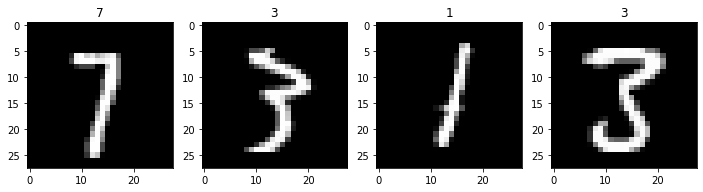

In [10]:
#@title Loading the data
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

data_shape = (1, 28, 28)

# Plot a few examples
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
  im, label = mnist[random.randint(0, len(mnist))]
  axs[i].imshow(im.squeeze(), cmap='gray')
  axs[i].set_title(label)

### 2.2 Defining Our Network

The convolution operation is handled by the `nn.Conv2d` layer. Uncomment the next line to view some info about this:

In [11]:
# ?nn.Conv2d

Let's use nn.Conv2D to convolve this image with some random kernels:

In [12]:
conv_test = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5,
                           padding=0)
image = mnist[0][0].unsqueeze(0) # unsqueeze to make this a 'batch of size 1'
print('Input shape: ', image.shape) # One channel greyscale image
print('Output shape: ', conv_test(image).shape) # 12 output channels (from 12 kernels)

Input shape:  torch.Size([1, 1, 28, 28])
Output shape:  torch.Size([1, 12, 24, 24])


Note the inal shape is slightly smaller - how does padding change this? Does the output shape make sense?

This layer has some trainable parameters: the kernels. Let's check these out:

In [13]:
conv_test.weight.shape # 12 filters, each 1x5x5 

torch.Size([12, 1, 5, 5])

Here's a network that uses these layers (along with nn.MaxPool2d for the downsampling/pooling). We could use nn.Sequential as in the previous example, but I'd like to show another common style here. We define all the layers we'll need in \_\_init__  but only in the forward() method do we actually specify how that data should flow through the network. 

In [14]:
# Network definition
class MiniCNN(nn.Module):
  def __init__(self):
    super(MiniCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10) # 10 outputs (for 10 digits)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

### 2.3 The Training Loop


![training](https://media3.giphy.com/media/xT0xekSmUwcoD6SxzO/giphy.gif)

Here's a training loop that should now be getting quite familiar. A few noteworthy things:
- We can't push all the images through in one go, so within each epoch (i.e. each full psas through the data) we do multiple batches. This is when 'Gradient Descent' becomes 'Stochastic Gradient Descent' or 'Mini-batch GD' depending on who you're talking to. PyTorch does the batching for us via something called a `DataLoader`. 
- We'd like to train on the GPU, so we need to make sure both the model and the data are on the right device with `.to(device)` (device is defined earlier).
- We're using a loss function that is good for classification tasks: `nn.CrossEntropyLoss()`. Accuracy has 'steps' and so it makes differentiation tricky. By treating the outputs of the network as probabilities we can see how confident it is that something is in a specific class while keeping everything continuous and differentiable. Don't worry too much about this :)

In [15]:
# Data in dataloader
train_loader = DataLoader(mnist, batch_size=16, shuffle=True)

# Set up model, loss and optimizer
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

# The training loop
for epoch in range(2):
  print(f'Epoch {epoch}')
  for data, target in tqdm(train_loader, unit='batch'):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

Epoch 0


  0%|          | 0/3750 [00:00<?, ?batch/s]

Epoch 1


  0%|          | 0/3750 [00:00<?, ?batch/s]

ASIDE: remove all `to(device)` in the above code - is it slower on CPU? 

### 2.4 Evaluation - how well does it do?



![testing](https://media3.giphy.com/media/JRPftUYuIRw3axuh5y/giphy-downsized-large.gif)

In [16]:
## Testing
correct = 0
total = len(mnist_val)
test_loader = DataLoader(mnist_val, batch_size=16, shuffle=True)

with torch.no_grad():
  # Iterate through test set minibatchs
  for data, labels in tqdm(test_loader):
    data, labs = data.to(device), labels.to(device) # Move the data to GPU for faster execution.
    y = model(data) # Forward pass
    predictions = torch.argmax(y, dim=1) # The model has ten outputs, one for each digit. Here we take the index with the highest output
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct/total * 100:.2f}%')

  0%|          | 0/625 [00:00<?, ?it/s]

Test accuracy: 97.01%


In [18]:
#Exercise: See how good you can get! Tweak the architecture, the hyperparameters, the training time, the optimizer... go wild ;)

Phew! Welcome to deep learning :) 

We're learning just enough to move on and make art, but these are some big topics and we're barely scratching the surface. If you're interested in more of the theory or implementing some of these ideas from scratch, you might like to check out the content at https://deeplearning.neuromatch.io/ or one of the many deep learning courses on various MOOC platforms. If you'd like a more top-down approach to doing practical deep learning realy well, I can't recommend the [fastai course](https://course.fast.ai) highly enough. 

For now, let's look at a slightly more complex neural network that has been trained to classify many different classes of images. Specifically, we'll see if we can use the internal representations it has developed to do something artistic :)

# Section 3: Style Transfer

![style](https://c.tenor.com/dhmx9O--AjoAAAAC/style-like-your-style.gif)

Remember how we said that early layers in a network tend to learn simpler features like colour and texture, while later layers capture more complex shapes? We're going to take advantage of this to do a little bit of magic. We'll take two images, a content image and a style image. Then we'll feed both through a network and record the activations at various layers.

Now we can start with noise or begin with the content image, and set it up as a tensor to be optimised. Then, we start tweaking it such that when we feed it through the same big network the activations in the early layers ('style') are similar to those of the style image while the activations of later layers, more linked to overall structure and shapes ('content') match the content image. 

In effect we're trying to minimise some combination of two loss functions, a style loss and a content loss. 

First, let's look at a pretrained network and pull some features from it:

### 3.1 Extracting Represenations from Pretrained Models

VGG16 was a fairly popular CNN that improved upon the famous AlexNet architecture. It has since been supeceeded by more complex networks but it still works great for our purposes. The architecture is something like the following (source [link text](https://https://neurohive.io/en/popular-networks/vgg16/)):

![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

We can load it like so (check the imports section at the start of this notebook for the relevant imports):

In [25]:
vgg = vgg16(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# vgg # Uncomment to show the sumary

I adapted some code from [here](https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch) to create a feature extractor that will record the outputs of neurons in specified layers:

In [18]:
#@title VGG16 Feature Extractor 

# Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        self.features = vggModel.features
        
        #desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        #making this model's parameters untrainble
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()  #outputs from the selected layers
        
        #for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) #apply the layer
            
            #if this layer is a desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)
                
                #check if we got all desired layers
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs


To test it out, let's download a couple of images which we'll later use to try style transfer:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58517  100 58517    0     0   365k      0 --:--:-- --:--:-- --:--:--  388k


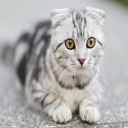

In [19]:
#@title content_image
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
content_image = Image.open('cat.jpeg').resize((128, 128))
content_image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200k  100  200k    0     0  1744k      0 --:--:-- --:--:-- --:--:-- 1760k


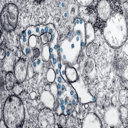

In [20]:
#@title style_image
# https://images.pexels.com/photos/5683489/pexels-photo-5683489.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1
# 
# https://images.pexels.com/photos/413195/pexels-photo-413195.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1
!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
style_image = Image.open('style.jpeg').resize((128, 128))
style_image

In [21]:
# A convenience function for going from a PIL image to a tensor:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0)

Extracting the activations from a few later layers to serve as our content features:

In [22]:
content_im_tensor = pil_to_torch(content_image)
contentExtractor = VGGFeatureExtractor(vgg,  [15, 19])
target_content_features = contentExtractor(content_im_tensor)
# View the shapes of the extracted features (one tensor for each layer):
[t.shape for t in target_content_features] 

[torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])]

And likewise from some early layers to use in the style loss:

In [23]:
styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])
style_im_tensor = pil_to_torch(style_image)
target_style_features = styleExtractor(style_im_tensor)
[t.shape for t in target_style_features] 

[torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16])]

We feed in an image and get back these tensors recording the activations of various neurons in specific layers of the network - the 'internal representations' which we'll use in our loss functions.

### 3.2 Defining the loss functions

For our content loss we'll keep things simple, with a measure of how large the differences between the two sets of features are (l1 loss, think of it as mean absolute error):

In [26]:
def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

im = torch.rand(1, 3, 128, 128)
content_loss(im, target_content_features)

tensor(2.7186)

The style loss is a little more tricky. We want to measure the occurence of similar features, but we don't care so much where they occur in the image. Using L1 loss as above would mean it just tried to copy the style image (layout and all). To get around this, we create something called a gram matrix for each set of features, and compare these gram matrices instead of comparing the features directly. This is one of those things where most tutorials/explanations online don't give any explanation for why we do this specifically, and I don't know the theory myself so we're going going to roll with this ¯\_(ツ)_/¯

In [27]:
# The gram matrix
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(207.6196)

NB: These two losses are quite different size-wise. This can sometimes mean that one will 'overpower' the other. We'll partly address this by adding some parameters to scale both losses and adjust how much each one contributes to the final loss value. In this case you'll also notice that while the style_loss starts out high it rapidly falls as small changes to the image being optimised take effect.

### 3.3 Yet Another Optimization Loop

With our loss functions in place, let's try it out!

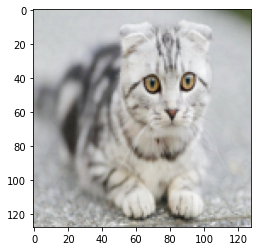

88.84683227539062


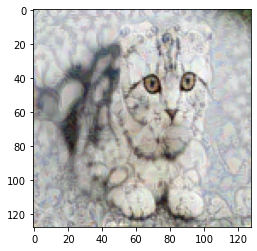

2.903740882873535


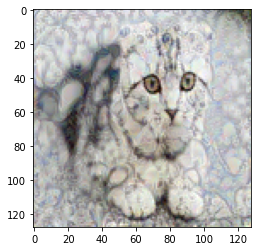

1.5520429611206055


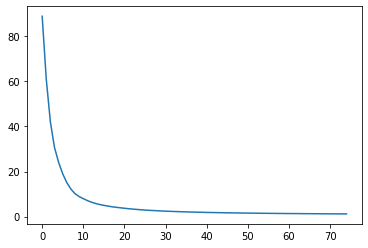

In [30]:
# Start with a copy of the content image
im = pil_to_torch(content_image)
im.requires_grad = True

# Optimizer
optimizer = torch.optim.AdamW([im], lr=5e-3)

# Weights we'll give to the different losses
style_weight, content_weight = 1, 0.1

# The training loop (look familiar yet?)
losses = []  # keeping recods of loss
for i in range(75):
  optimizer.zero_grad()  # set gradients to 0
  loss = style_weight * style_loss(im.clip(0, 1), target_style_features)
  loss += content_weight * content_loss(im.clip(0, 1), target_content_features)
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step) 

  # Storing our loss for later viewing
  losses.append(loss.item())

  # Showing the progress occasionally
  if i % 25 == 0:
    plt.imshow(im.clip(0, 1).detach().squeeze().permute(1, 2, 0))
    plt.show()
    print(loss.item())

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

Hooray - that sort of works!

### 3.4 Tidy Version

Here's all that again with a few extra tweaks and everything in one place to make it easier to try things. Some of the changes:
- The output now updates as things progress so you can see what's happening
- We add some image augmentation via torchvision transforms. 
- A nice neat form to make changing parameters easier

I should stress here that this is just my attempt at a no-frills style transfer setup for learning purposes. All parameters are chosen on a whim, and I'm probably missing many improvements that have been made by lots of smart people in the years since this technique was first discovered. I recommend looking around for a PyTorch style transfer notebook online to see how others have done it - the code will look different but now at least you'll know the core idea and be able to see what they do differently :)


You can download images and upload via the files interface on the left, or use curl as shown here:



In [31]:
# Downloading a new style image
!curl --output fire.jpeg "https://images.pexels.com/photos/207353/pexels-photo-207353.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51918  100 51918    0     0  71575      0 --:--:-- --:--:-- --:--:-- 71512


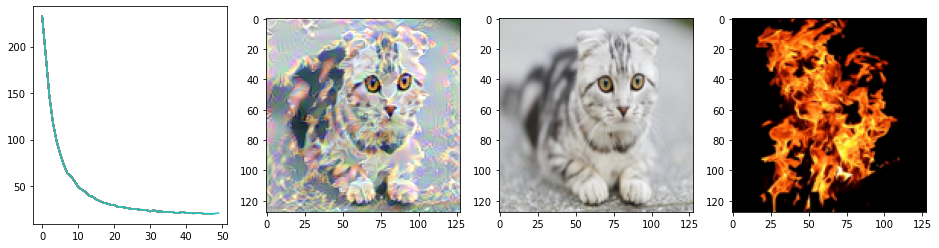

In [33]:
#@title Style Transfer

width = 128 #@param
height = 128 #@param
style_image_path = 'fire.jpeg' #@param
style_image = Image.open(style_image_path).resize((width, height))
content_image_path = 'cat.jpeg' #@param
content_image = Image.open(content_image_path).resize((width, height))

content_layers = [19] #@param
contentExtractor = VGGFeatureExtractor(vgg,  content_layers).to(device)
content_im_tensor = pil_to_torch(content_image).to(device)
target_content_features = contentExtractor(content_im_tensor)

style_layers = [5, 7, 10, 12, 17] #@param
styleExtractor = VGGFeatureExtractor(vgg,style_layers).to(device)
style_im_tensor = pil_to_torch(style_image).to(device)
target_style_features = styleExtractor(style_im_tensor)

# Start with a copy of the content image
im = pil_to_torch(content_image).to(device)
im.requires_grad = True

# We'll do a little data augmentation just for fun
tfms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
])

lr=0.01 #@param
optimizer = torch.optim.AdamW([im], lr=lr)

# Weights we'll give to the different losses
style_weight = 0.1 #@param
content_weight = 0.9 #@param

n_tfms = 4 #@param


# Display
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) # One for each prompt
p = display(fig,display_id=True)

# The training loop
losses = []  # keeping recods of loss
n_iter = 50 #@param
for i in range(n_iter): # 500 'epochs' of training
  optimizer.zero_grad()  # set gradients to 0
  loss = 0
  for i in range(n_tfms):
    loss += style_weight * style_loss(tfms(im.clip(0, 1)), target_style_features)
    loss += content_weight * content_loss(tfms(im.clip(0, 1)), target_content_features)
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step)

  # Storing our loss for later viewing
  losses.append(loss.item())
  if i % 3 == 0:
    with torch.no_grad():
      axs[0].plot(losses, label='Loss:'+str(loss.item()))
      axs[1].imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
      axs[2].imshow(content_image)
      axs[3].imshow(style_image)
      p.update(fig)

ipd.clear_output()
p.update(fig)

# BONUS 1: Auto-Encoders, Learned Representations and VAEs

We've seen that pre-trained networks can learn representations that are useful for classification. And that we can use some of these learned representations to create a measure of structural or stylistic similarity between images, which we can re-purpose for style transfer. 

How does this idea of learning useful representations tie into generating new images? 

In this section we'll meet something called an autoencoder.

![ae](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)

The idea here is to make a neural network with two parts: and encoder and a decoder. The encoder will take an image and process it until, at some point, we reach a 'bottleneck' layer where only a handful of numbers are passed to the next layer. We call this small set of numbers `h` or `z`* or 'the latent representation of the image'. The task of the network during training is to learn how to produce a useful representation so that the decoder can re-create the input image with minimal loss. 

By setting things up in this way, we're forcing the network to learn enough about the data to create a useful representation AND a decoder network that can create nice outputs despite only seeing this very compressed representation of the input image. 

Take a moment to appreciate this: as with many things in deep learning, we don't do anything too special ourselves - we just set an objective and let the network learn how to do things!

*some people are picky about notation, but we'll be fairly flexible and just try to clarify what something is rather than relying too heavily on one poor letter for meaning.

### Creating a Convolutional AutoEncoder

Here we build on the simple networks we made earlier on the lesson to create our network. Skim the code and see if you cn understand how the encoder and decoder work. Note that `ConvTranspose2d` is effectively the reverse of a convolution layer - check the docs for details.

In [34]:
class ConvAE(nn.Module):
  def __init__(self, hdim=20):
    super(ConvAE, self).__init__()
    # Encoder layers
    self.enc_conv1 = nn.Conv2d(1, 32, 3)
    self.enc_conv2 = nn.Conv2d(32, 32, 3)
    self.enc_fc1 = nn.Linear(32*24*24, 128)
    self.enc_fc2 = nn.Linear(128, hdim)

    # Decoder layers
    self.dec_fc1 = nn.Linear(hdim, 128)
    self.dec_fc2 = nn.Linear(128, 32*24*24)
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
    self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
    self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

  def encode(self, x):
    x = self.enc_conv1(x)
    x = F.relu(x)
    x = self.enc_conv2(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.enc_fc1(x)
    x = F.relu(x)
    x = self.enc_fc2(x)
    return x

  def decode(self, x):
    x = self.dec_fc1(x)
    x = F.relu(x)
    x = self.dec_fc2(x)
    x = F.relu(x)
    x = self.dec_unflatten(x)
    x = self.dec_conv1(x)
    x = F.relu(x)
    x = self.dec_conv2(x)
    return x

  def forward(self, x):
    return self.decode(self.encode(x))

torch.Size([1, 20])
torch.Size([1, 1, 28, 28])


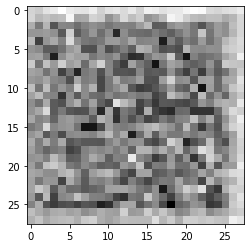

In [35]:
# Create a network as defined above and pass an image through it
ae = ConvAE()
encoded = ae.encode(mnist[0][0].unsqueeze(0))
print(encoded.shape)
decoded = ae.decode(encoded)
print(decoded.shape)
plt.imshow(decoded.detach().squeeze(), cmap='gray')

Time to train it. I stole most of this code from the NMA content on this topic, which is where I'd suggest you start if you want to go deeper.

In [36]:
def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in tqdm(range(epochs)):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1

train_autoencoder(ae, mnist, device)

  0%|          | 0/20 [00:00<?, ?it/s]

After traiing, we no longer get the noisy nothingness we saw as the output of the network. Instead, the images look impressively close to the originals! You could try lowering the size of the hidden dimension and seeing how far you can push it.

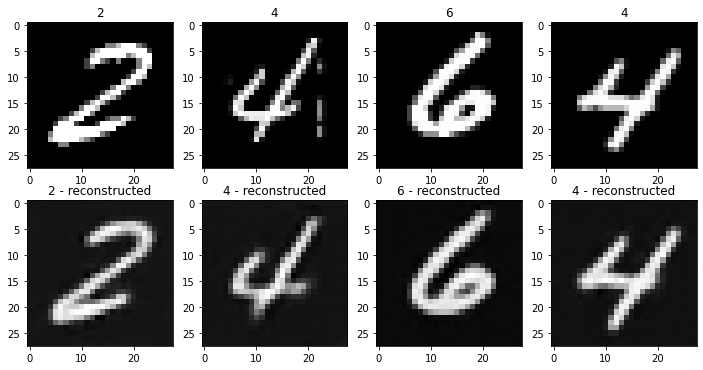

In [37]:
# Plot the reconstructed versions of some random samples from the validation set
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
  im, label = mnist_val[random.randint(0, len(mnist_val))]
  axs[0][i].imshow(im.squeeze(), cmap='gray')
  axs[0][i].set_title(label)
  axs[1][i].imshow(ae(im.unsqueeze(0).to(device)).squeeze().detach().cpu(), cmap='gray')
  axs[1][i].set_title(str(label) + ' - reconstructed')

Autoencoders are great, and have many uses (data compression, for example). But they aren't so great at producing new images that look like the training data. Ideally, we'd pick a random point in the latent space (i.e. a set of random numbers to be the `h`) and run it through the decoder to get something that looks like a real image. Instead, if we try this we see mostly strange alien shapes:

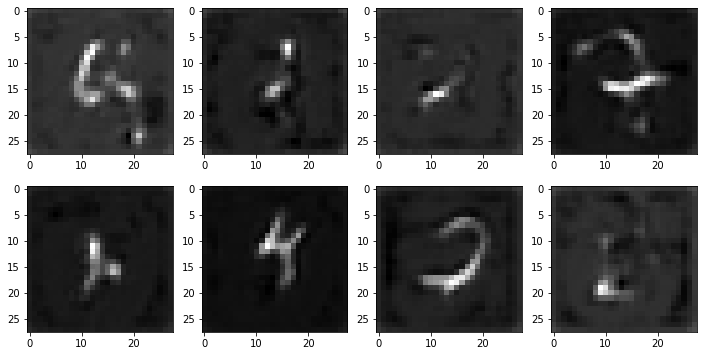

In [38]:
# Generate new images from random zs
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
  im = ae.decode(torch.randn(1, 20).to(device))
  axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

This is because the autoencoder learns to map different image classes to drastically different parts of the latent space - there is no incentive for it to learn a 'neat' representation, only that it learns one that let's it solve the problem as we framed it. 

To 'fix' this, we need to add an additional component to the loss which stops it from keeping all the latent representations wildly separated. The details are technical and you're brain is probably feeling a little full, so we won't actually try this ;) Just know that once we add this extra magical bit of code, we get something called a VARIATIONAL auto-encoder ('VAE') which enerates new images that look much closer to the training data. If there's interest I may make this the subject of a bonus notebook.

For a deeper dive into all of this, check out https://deeplearning.neuromatch.io/tutorials/W2D5_GenerativeModels/student/W2D5_Tutorial1.html

# BONUS 2: CLIP Fun

OK, enough theory for today! Let's use our wonky auto-encoder from before to make some images. 

We scatter various glyphs at random locations, each generated by 20 numbers (the `z`s) which will be fed into the decoder part of our AE to generate the symbols. 

The output image is just a bunch of these symbols brightened by some factor (`scales`) and summed together.

Let's start by testing this process, making 50 glyphs and scattering them about:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


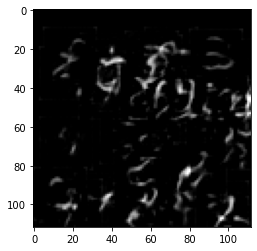

In [42]:
w, h = 112, 112
n = 50

offsets = np.array(torch.rand((n, 2)) * torch.tensor([w, h]).unsqueeze(0)).astype(int)

# We'll mess with z
z = torch.randn(n, 20).to(device)

def get_out_im(z):
  outs = ae.decode(z)
  im = torch.zeros((1, w, h)).to(device)
  for i, (x, y) in enumerate(offsets):
   im[:,x:x+28, y:y+28] += outs[i][:,:min(28, w-x),:min(28, h-y)]

  return im

im = get_out_im(z)

plt.imshow(torch.stack([im, im, im], dim=1).squeeze().detach().cpu().permute(1, 2, 0))

Now it's time to pull in CLIP tha magical box once again:

In [43]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

In [45]:
from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

cuda:0
224


We'll make our image as above, then feed it through CLIP to compare it with a text prompt. We'll then optimize the zs that were used to generate the glyphs rather than the image itself as last week) to move slowly towards an image that (ideally) looks like the prompt:

  0%|          | 0/300 [00:00<?, ?it/s]

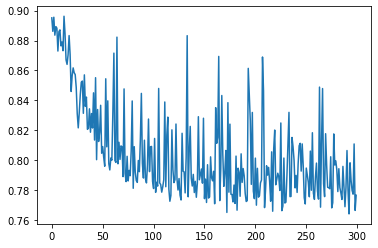

In [52]:
!mkdir -p steps
!rm steps/*.png
           # Specifyi     ng some transforms to apply to our image:
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# Our new and improved loss function
def clip_loss(im, text_embed):
  image_embed = perceptor.encode_image(tfms(im).to(device)).float()
  input_normed = F.normalize(image_embed.unsqueeze(1), dim=2)
  embed_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

# The target text as a parameter:
prompt = "sea" #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt).to(device)).float()

w, h = 300, 300
n = 500
offsets = np.array(torch.rand((n, 2)) * torch.tensor([w, h]).unsqueeze(0)).astype(int)

# We'll mess with z
z = torch.randn(n, 20).to(device)
z.requires_grad=True

# We'll also scale the intensities and optimize this as well
scales = torch.ones(n)
scales.requires_grad = True

ae = ae.to(device)

# An optimizer (you can try others) with the image layers as parameters
optimizer = torch.optim.Adam([z, scales], lr=0.1) # optim.SGD([z, scales], lr=50)

# Somewhere to track our losses
losses = []

# A basic progress bar (using fastprogress)

for i in tqdm(range(300)):
  optimizer.zero_grad()
  im = get_out_im(z) # Get the image 
  im = torch.stack([im, im, im], dim=1) # Reshape to 3-channel image (could use .repeat or .view)
  l = clip_loss(im, text_embed) # Calculate loss
  losses.append(float(l.detach().cpu())) # Store loss
  l.backward() # Backprop
  optimizer.step() # Update

  with torch.no_grad():
    Image.fromarray((im.cpu().squeeze().clip(0, 1).permute([1, 2, 0]) * 255).numpy().astype(np.uint8)).save(f'steps/step{i:04}.png')

plt.plot(losses)

The final result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


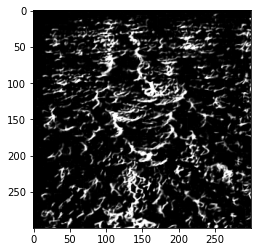

In [53]:
im = get_out_im(z)
plt.imshow(torch.stack([im, im, im], dim=1).squeeze().detach().cpu().permute(1, 2, 0))

In [42]:
#@title Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/step%04d.png -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

This is neat, although in it's current incarnation not particularly useful. However, it gives us one key insight that will serve us well next week: instead of working on optimizing raw pixel values, we're using a generative network (in this case our bad autoencoder) that has already learnt a lot about how to generate plausible images based on some training data and then we're using that network to generate the image from a (relatively small) set of numbers (the zs) which we can optimise. To put it more succinctly, we're optimising the inputs to a generative network rather than trying to optimise a giant array of raw pixels. This will come in handy when we play with GANs next week :)